# Image Captioning with Attention

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import image

import itertools
import random

tf.random.set_seed(1)

Loading the Data. The data consist of pictures and labels of linear functions

In [2]:
import cv2
import os

def load_images_from_folder(folder, n_imgs=-1):
    images = []
    image_nums = []
    for filename in os.listdir(folder)[:n_imgs]:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            image_nums.append(filename.strip('.png'))
    return images, image_nums

folder="../../../Math Equations/linear_fcns/images"

In [23]:
def load_images(n_imgs=0):
    images = []
    image_nums = []
    if n_imgs == 0:
        for i in range(0,18719):
            img = cv2.imread(f'../../../Math Equations/linear_fcns/images/{i}.png')
            if img is not None:
                images.append(img)
                image_nums.append(str(i))
        return images, image_nums
    if n_imgs != 0:
        for i in range(0,n_imgs):
            img = cv2.imread(f'../../../Math Equations/linear_fcns/images/{i}.png')
            if img is not None:
                images.append(img)
                image_nums.append(str(i))
        return images, image_nums



In [4]:
images, fnames = load_images_from_folder(folder,10)

In [34]:
images, fnames = load_images()

In [25]:
fnames

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [35]:
labels = pd.read_csv('../../../Math Equations/linear_fcns/data.csv')

In [36]:
labels['img_number'] = labels['filename'].apply(lambda x: x.split('/')[-1].strip('.png'))

In [37]:
labels.head()

,latex,filename,img_number
0,0a+1=2,linear_fcns/images/0.png,0
1,0b+1=2,linear_fcns/images/1.png,1
2,0c+1=2,linear_fcns/images/2.png,2
3,0d+1=2,linear_fcns/images/3.png,3
4,0e+1=2,linear_fcns/images/4.png,4


In [38]:
label_array = labels[labels['img_number'].isin(fnames)]['latex'].values

For the labels we need to add start and end tokens so the model can recognize what to write.

In [39]:
label_array = [f'\t{la}\n' for la in label_array]

Let's reshape the images so we can plot them.

In [40]:
images_for_split = images
images = np.array(images)
images = 255 - images
images.shape

(18719, 72, 360, 3)

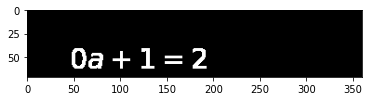

In [45]:
plt.imshow(images[0].squeeze())

In [46]:
label_array[0]

'\t0a+1=2\n'

Now we can process them and prepare them for inceptionv3 which is transfer learning

In [47]:
img_train, img_test, img_train_name, img_test_name = train_test_split(images, label_array, test_size=.3)

In [12]:
img_mini = tf.image.resize_with_pad(img_train, 299,299)
img_test= tf.image.resize_with_pad(img_test, 299,299)

In [13]:
img_mini = tf.keras.applications.inception_v3.preprocess_input(img_mini)
img_test = tf.keras.applications.inception_v3.preprocess_input(img_test)

Now we can load the features of the inceptionv3 model as seen below.

In [14]:
img_mini0 = (img_mini[0] + 1) / 2

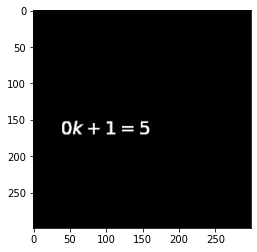

In [15]:
plt.imshow(tf.squeeze(img_mini0))

In [3]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [20]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices((img_mini, img_train_name)).batch(500)#(img_mini, label_array)).batch(1)
c = 1

for img, label in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
    p = f'../Batch Features Train/batch_features{c}'
    c = c+1 
     #path_of_feature = p.numpy().decode("utf-8")
    np.save(p, batch_features)

In [17]:
img_load = np.load('../Batch Features Train/batch_features1.npy')
for i in range(2,61):
    img_add = np.load(f'../Batch Features Train/batch_features{i}.npy')
    img_load = np.concatenate((img_load, img_add))

FileNotFoundError: [Errno 2] No such file or directory: '../Batch Features Train/batch_features15.npy'

In [38]:
img_load_test = np.load('../Batch Features Test/batch_features1.npy')
for i in range(2,61):
    img_add = np.load(f'../Batch Features Test/batch_features{i}.npy')
    img_load_test = np.concatenate((img_load_test, img_add))

FileNotFoundError: [Errno 2] No such file or directory: '../Batch Features Test/batch_features7.npy'

In [18]:
img_load.shape

(7000, 64, 2048)

### Tokenizing the labels

Now we can pad the labels to make sure they are all the same length.

In [19]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [20]:
# Choose the top 5000 words from the vocabulary
top_k = 41
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters=' ',
                                                  char_level=True)
tokenizer.fit_on_texts(img_train_name)#label_array)
train_seqs = tokenizer.texts_to_sequences(img_train_name)

# Padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(img_train_name)
test_seqs = tokenizer.texts_to_sequences(img_test_name)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
cap_vector_test = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [21]:
tokenizer.get_config()

{'num_words': 41,
 'filters': ' ',
 'lower': True,
 'split': ' ',
 'char_level': True,
 'oov_token': '<unk>',
 'document_count': 7000,
 'word_counts': '{"\\t": 7000, "0": 1991, "n": 284, "+": 7000, "2": 1990, "=": 7000, "8": 2165, "\\n": 7000, "5": 2160, "t": 270, "6": 2148, "1": 2112, "v": 264, "3": 2075, "7": 2157, "i": 294, "a": 265, "9": 2147, "l": 262, "x": 250, "o": 274, "4": 2055, "g": 276, "b": 277, "k": 282, "p": 277, "q": 271, "c": 249, "h": 275, "z": 272, "f": 288, "e": 266, "u": 275, "s": 252, "j": 274, "w": 250, "y": 279, "m": 261, "r": 270, "d": 243}',
 'word_docs': '{"\\t": 7000, "2": 1990, "=": 7000, "+": 7000, "8": 2165, "\\n": 7000, "0": 1991, "n": 284, "6": 2148, "1": 2112, "t": 270, "5": 2160, "v": 264, "3": 2075, "7": 2157, "i": 294, "a": 265, "9": 2147, "l": 262, "x": 250, "o": 274, "4": 2055, "g": 276, "b": 277, "k": 282, "p": 277, "q": 271, "c": 249, "h": 275, "z": 272, "f": 288, "e": 266, "u": 275, "s": 252, "j": 274, "w": 250, "y": 279, "m": 261, "r": 270, "d"

In [22]:
max_length

8

In [23]:
print(f'{label_array[0]} -> {train_seqs[0]}')

	0i+1=2
 -> [2, 14, 18, 3, 15, 4, 6, 5]


In [24]:
import json

char_to_int_map = tokenizer.get_config()['word_index']
char_to_int_map = json.loads(char_to_int_map)
[char_to_int_map[c] for c in img_train_name[0]]

[2, 14, 18, 3, 15, 4, 6, 5]

In [25]:
# Feel free to change these parameters according to your system's configuration
embedding_dim = 45
units = 32
vocab_size = top_k + 1
num_steps = len(img_train) // 1
val_num_steps = ;en(img_test) // 1
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

## Model

Below we are defining the attention, the encoder and the decoder. The encoder is just a fully connected layer from the features already extracted.

In [70]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [71]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        #print(f'This is x: {x}')
        x = tf.nn.relu(x)
        #print(f'This is x: {x}')
        return x

In [72]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        #print('decoder attention complete')

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        #print('decoder embedding complete')
        #print(f'x.shape = {x.shape}')
        #print(f'context_vector.shape = {context_vector.shape}')

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        #print('decoder embedding + context vector complete')

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        #print('decoder gru complete')

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        #print('decoder fc1 complete')

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        #print('decoder reshape complete')

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        #print('decoder fc2 complete')

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [73]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [74]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [75]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [76]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
      start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
      # restoring the latest checkpoint in checkpoint_path
      ckpt.restore(ckpt_manager.latest_checkpoint)

In [77]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
val_loss_plot = []

In [78]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

          # initializing the hidden state for each batch
          # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    #print(f'hidden complete: {hidden}')

    # Create a vector of all \t indices to indicate the start of prediction
    dec_input = tf.expand_dims([tokenizer.word_index['\t']] * target.shape[0], 1)
    #print(f'dec_input complete: {dec_input}')

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        #print('encoder complete')
        #print(f'features.shape = {features.shape}')

        # iterate through timesteps to predict the i'th character
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            #print('decoder complete')

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [79]:
@tf.function # Non-teacher-forcing val_loss is too complicated at the moment
def val_step(img_tensor, target, teacher_forcing=True):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['\t']] * target.shape[0], 1)
    #print(dec_input.shape) # (BATCH_SIZE, 1)
    features = encoder(img_tensor)
    #print(features.shape) # (BATCH_SIZE, IMG_FEAT_LEN, ENCODER_HID) = 64 100 256
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))
    return loss, avg_loss

def cal_val_loss(val_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_loss, t_loss = val_step(img_tensor, target)
    
        total_loss += t_loss
    #print ('Valid Loss {:.6f}'.format(total_loss/val_num_steps))
    return total_loss/val_num_steps

In [80]:
image_dataset_encoded = tf.data.Dataset.from_tensor_slices((img_load, cap_vector)).batch(500)

In [81]:
val_dataset = tf.data.Dataset.from_tensor_slices((img_load_test, cap_vector_test)).batch(500)

In [87]:
import time
EPOCHS = 10

best_val_loss = 100

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(image_dataset_encoded):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        val_loss = cal_val_loss(val_dataset)

        if batch % 1 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    val_loss_plot.append(val_loss)

    if epoch % 5 == 0:
        #ckpt_manager.save() 
    print(num_steps)
    print ('Epoch {} Loss {:.6f} Val Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, val_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
     

Valid Loss 1.501949
Epoch 1 Batch 0 Loss 1.5026
Valid Loss 1.499677
Epoch 1 Batch 1 Loss 1.4993
Valid Loss 1.497694
Epoch 1 Batch 2 Loss 1.4981
Valid Loss 1.495481
Epoch 1 Batch 3 Loss 1.4963
Valid Loss 1.493724
Epoch 1 Batch 4 Loss 1.4971
Valid Loss 1.491798
Epoch 1 Batch 5 Loss 1.4934
Valid Loss 1.490412
Epoch 1 Batch 6 Loss 1.4907
Valid Loss 1.488286
Epoch 1 Batch 7 Loss 1.4901
Valid Loss 1.487055
Epoch 1 Batch 8 Loss 1.4864
Valid Loss 1.484798
Epoch 1 Batch 9 Loss 1.4843
Valid Loss 1.482996
Epoch 1 Batch 10 Loss 1.4825
Valid Loss 1.480337
Epoch 1 Batch 11 Loss 1.4828
Valid Loss 1.477872
Epoch 1 Batch 12 Loss 1.4769
Valid Loss 1.470783
Epoch 1 Batch 13 Loss 1.4766
7000
Epoch 1 Loss 0.002980
Time taken for 1 epoch 74.03370809555054 sec

update best val loss from 100.0000 to 1.4708
Valid Loss 1.849504
Epoch 2 Batch 0 Loss 1.4709
Valid Loss 2.393610
Epoch 2 Batch 1 Loss 1.8317
Valid Loss 2.583843
Epoch 2 Batch 2 Loss 2.3810
Valid Loss 2.517557
Epoch 2 Batch 3 Loss 2.5814
Valid Loss 2.4

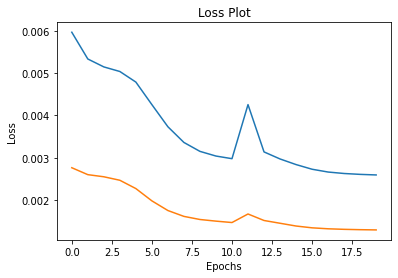

In [88]:
plt.plot(loss_plot)
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Evaluate

In [90]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    #print(attention_plot.shape)

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(image, 0)
    #print(temp_input)
    img_tensor_val = image_features_extract_model(temp_input)
    #print(img_tensor_val)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    #print(img_tensor_val)
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['\t']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        #print(attention_weights.shape)
        attention_plot[i] = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.random.categorical(predictions, 1)[0][0]
        predicted_id = int(predicted_id)
        result.append(tokenizer.index_word[predicted_id])
        #print(tokenizer.index_word[predicted_id])
        ind = np.argpartition(predictions, -4)[0][-4:]
        #print(f'These are the top choices {"".join(tokenizer.index_word[c] for c in ind)}')
        #print(f'This are the probabilities {predictions.numpy()[0,ind]}')

        if tokenizer.index_word[predicted_id] == '\n':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [91]:
def plot_attention(image, result, attention_plot):
    
    #-1 goes to zero
    temp_image = np.array(image)
    temp_image = (temp_image + 1) / 2

    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show();

Run attention_plot to see what it looks like

Prediction Caption: 2 o + 7 = 3 



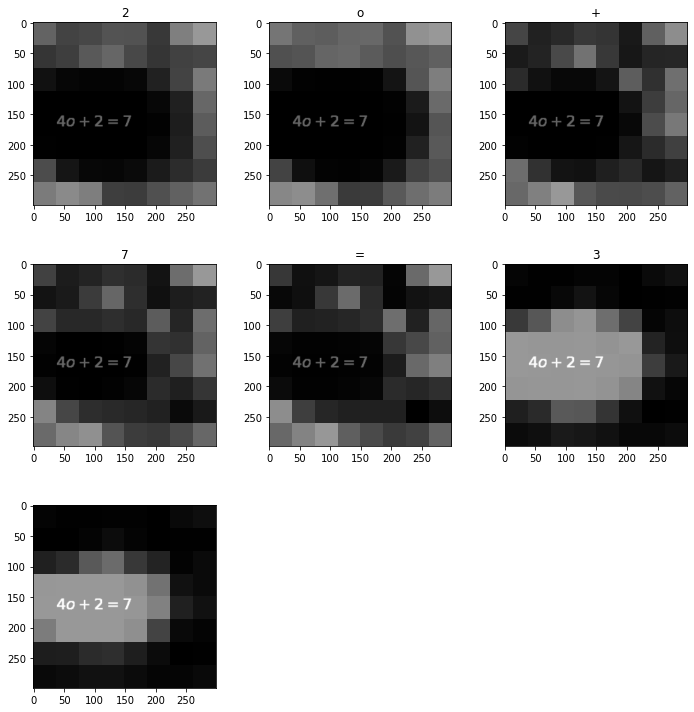

In [92]:
result, attention_plot = evaluate(img_test[0])
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_test[0], result, attention_plot)
# opening the image

Prediction Caption: 1 r + 6 = 2 



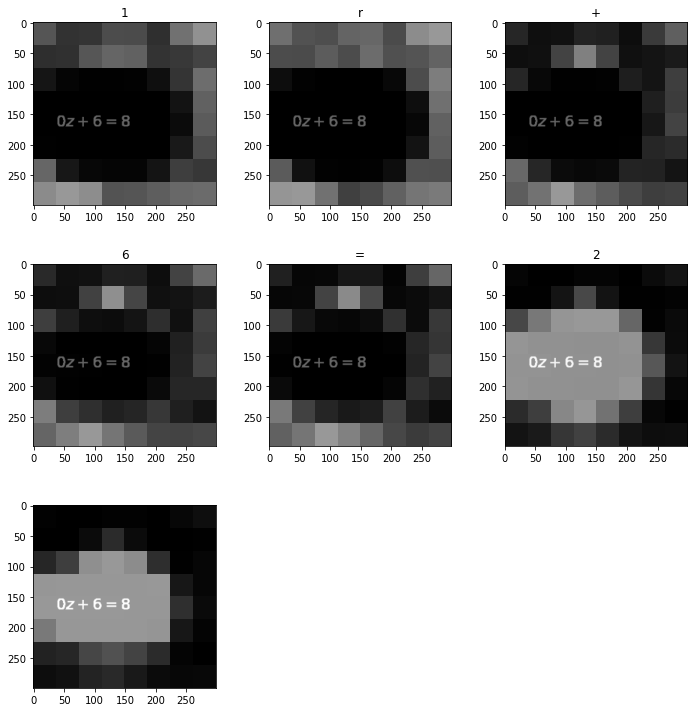

In [93]:
result, attention_plot = evaluate(img_test[9])
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_test[9], result, attention_plot)
# opening the image

Prediction Caption: 0 u + 7 = 6 



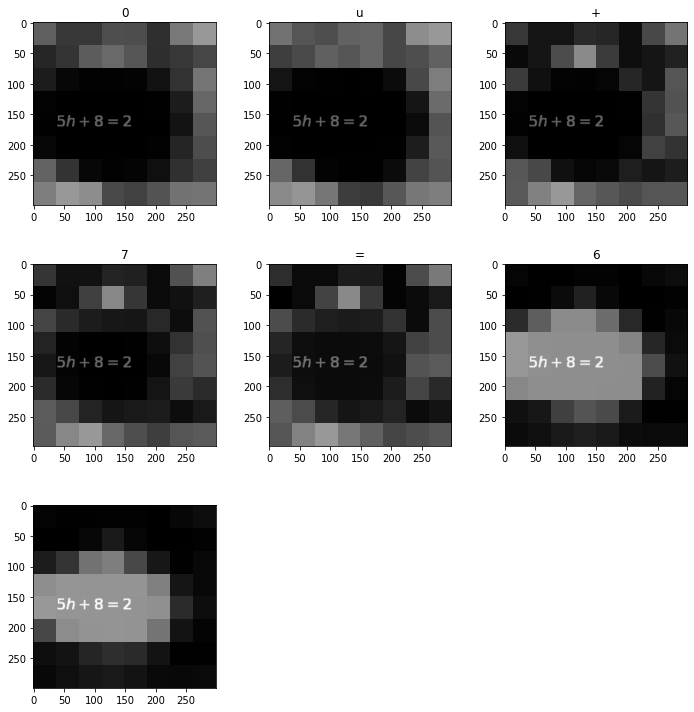

In [94]:
result, attention_plot = evaluate(img_test[5])
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_test[5], result, attention_plot)
# opening the image

In [95]:
def check_results(images, labels, num_imgs=10):
    for i in range(0, num_imgs):
        result, attention_plot = evaluate(images[i])
        print('Prediction Caption:', ' '.join(result))
        print(f'Actual Caption: ', labels[i])
        #plot_attention(images[i], result, attention_plot)

In [96]:
check_results(img_test[20:50], img_test_name[20:50])

Prediction Caption: 4 t + 0 = 8 

Actual Caption:  	1q+9=4

Prediction Caption: 4 n 8 = 8 

Actual Caption:  	4k+3=1

Prediction Caption: 2 u + 0 = 2 

Actual Caption:  	0r+5=9

Prediction Caption: 2 m + 2 = 6 

Actual Caption:  	7a+9=6

Prediction Caption: 3 k + + 0 = 5 

Actual Caption:  	0k+8=4

Prediction Caption: 9 b + 8 = 0 

Actual Caption:  	0i+5=1

Prediction Caption: 7 x + 7 = 5 

Actual Caption:  	4q+0=6

Prediction Caption: d 6 o + 6 = 4 

Actual Caption:  	2s+0=4

Prediction Caption: 1 o + 4 = 3 

Actual Caption:  	7l+1=9

Prediction Caption: 6 a + 6 = 9 

Actual Caption:  	3b+9=5

